In [1]:
import torchaudio


torchaudio.datasets.SPEECHCOMMANDS(
    './' , 
    url = 'speech_commands_v0.02', 
    folder_in_archive= 'speech_commands_v0.02', 
     download = True,
)

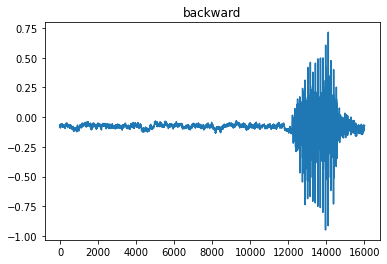

In [2]:
import matplotlib.pyplot as plt


subset = "speech_commands_v0.02"
label = "backward"
fname = "0165e0e8_nohash_0.wav"
filename = f"./{subset}/speech_commands_v0.02/{label}/{fname}"
waveform, sample_rate = torchaudio.load(filename)

plt.plot(waveform.t())
plt.title(label)
plt.show()

In [3]:
import glob


labels = ['follow', 'five', 'no', 'three', 'learn', 'bed', 'seven', 'on', 'marvin', 'right', 'forward', 'house', 'four', 'down', 'left', 'visual', 'wow', 'two', 'off', 'cat', 'happy', 'tree', 'yes', 'one', 'go', 'up', 'bird', 'stop', 'sheila', 'backward', 'dog', 'six', 'eight', 'zero', 'nine']

def load_data():
    data = []
    fnames = {
        "testing": "speech_commands_v0.02/speech_commands_v0.02/testing_list.txt",
        "validation": "speech_commands_v0.02/speech_commands_v0.02/validation_list.txt",
    }
    testing_set = set([fname.split("/")[-1] for fname in open(fnames["testing"]).read().split("\n")])
    validation_set = set([fname.split("/")[-1] for fname in open(fnames["validation"]).read().split("\n")])

    training_data = []
    testing_data = []
    validation_data = []

    for label_idx, label in enumerate(labels):
        audio_fnames = glob.glob(f"./speech_commands_v0.02/speech_commands_v0.02/{label}/*.wav")
        for audio_fname in audio_fnames:
            fname = audio_fname.split("/")[-1]
            if fname in testing_set:
                testing_data.append((audio_fname, label_idx))
            elif fname in validation_set:
                validation_data.append((audio_fname, label_idx))
            else:
                training_data.append((audio_fname, label_idx))

    return training_data, testing_data, validation_data

training_data, testing_data, validation_data = load_data()
print(len(training_data), len(testing_data), len(validation_data))

84843 11005 9981


In [4]:
import torch
from torch.utils.data import DataLoader, Dataset

class MySpeechCommandsDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.max_len = 16000

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        audio_fname, gt = self.dataset[index]
        waveform, sample_rate = torchaudio.load(audio_fname)

        n_waveform_pts = waveform.shape[1]
        n_pad = self.max_len - n_waveform_pts
        pad = torch.FloatTensor([[0 for _ in range(n_pad)]])
        inp = torch.hstack([waveform, pad])

        return inp, gt

train_dataset = MySpeechCommandsDataset(dataset=training_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, num_workers=0, shuffle=True)
inp, gt = next(iter(train_loader))
inp.shape, inp.type(), gt.shape

(torch.Size([2, 1, 16000]), 'torch.FloatTensor', torch.Size([2]))

In [5]:
import torch.nn as nn


class Model(nn.Module):
    def __init__(self, num_class, n_input=1, n_output=35, stride=16, n_channel=32):
        super(Model,self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(n_channel, n_channel, kernel_size=3),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3),
            nn.BatchNorm1d(2 * n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3),
            nn.BatchNorm1d(2 * n_channel),
            nn.ReLU(),
            nn.MaxPool1d(4),
        )
        
        self.flatten = nn.Flatten()
        
        self.classifer = nn.Linear(192, num_class)
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifer(x)
        return x 

model = Model(num_class=len(labels))
out = model(inp)
out.shape

torch.Size([2, 35])

In [6]:
from tqdm import tqdm

import numpy as np
import torch.optim as optim

def train(model, dataloader, optimizer, criterion):
    if torch.cuda.is_available():
        model = model.to("cuda")

    correct = 0
    total = 0
    train_losses = []

    model.train()
    for data in tqdm(dataloader):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

        optimizer.zero_grad()

        outputs = model(inputs.float())

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total
    return model, acc, np.mean(train_losses)

def validate(model, dataloader, criterion):
    if torch.cuda.is_available():
        model = model.to("cuda")

    correct = 0
    total = 0
    valid_losses = []

    expected = []
    actual = []

    model.eval()
    for data in tqdm(dataloader):
        inputs, labels = data

        if torch.cuda.is_available():
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        valid_losses.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        expected += labels.cpu()
        actual += predicted.cpu()

    acc = correct / total
    return model, acc, np.mean(valid_losses), expected, actual

train_dataset = MySpeechCommandsDataset(dataset=training_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=2, shuffle=True)
valid_dataset = MySpeechCommandsDataset(dataset=validation_data)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, num_workers=2, shuffle=True)
model = Model(num_class=len(labels))

train_losses = []
valid_losses = []
n_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
for epoch in range(n_epochs):
    model, train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    model, valid_acc, valid_loss, _, _ = validate(model, valid_loader, criterion)
    print("Epoch:", epoch, "train_acc:", train_acc, "valid_acc:", valid_acc, "train_loss:", train_loss, "valid_loss:", valid_loss)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

100%|██████████| 156/156 [00:02<00:00, 59.21it/s]


Epoch: 0 train_acc: 0.3606897445870608 valid_acc: 0.5858130447850917 train_loss: 2.396708386695942 valid_loss: 1.5634341530310802


100%|██████████| 156/156 [00:02<00:00, 56.87it/s]


Epoch: 1 train_acc: 0.6413257428426623 valid_acc: 0.7114517583408476 train_loss: 1.3366775717221053 valid_loss: 1.0913983021791165


100%|██████████| 156/156 [00:02<00:00, 58.95it/s]


Epoch: 2 train_acc: 0.7266008981294863 valid_acc: 0.7720669271616071 train_loss: 0.9978512290915752 valid_loss: 0.8512931500489895


100%|██████████| 156/156 [00:02<00:00, 58.23it/s]


Epoch: 3 train_acc: 0.7710241269167757 valid_acc: 0.7951107103496644 train_loss: 0.8353188166656106 valid_loss: 0.7473818059915152


100%|██████████| 156/156 [00:02<00:00, 58.95it/s]


Epoch: 4 train_acc: 0.7943967092158457 valid_acc: 0.8130447850916742 train_loss: 0.740797207276386 valid_loss: 0.685481244745927


100%|██████████| 156/156 [00:02<00:00, 58.22it/s]


Epoch: 5 train_acc: 0.8128896903692703 valid_acc: 0.8292756236850015 train_loss: 0.6693250228107245 valid_loss: 0.6165501391276335


100%|██████████| 156/156 [00:02<00:00, 56.54it/s]


Epoch: 6 train_acc: 0.8257958818052167 valid_acc: 0.8357879971946699 train_loss: 0.6256030532299663 valid_loss: 0.5904005494637367


100%|██████████| 156/156 [00:02<00:00, 58.64it/s]


Epoch: 7 train_acc: 0.8366630128590455 valid_acc: 0.8399959923855325 train_loss: 0.5827447901034607 valid_loss: 0.5775244604700651


100%|██████████| 156/156 [00:03<00:00, 47.40it/s]


Epoch: 8 train_acc: 0.8445245924825855 valid_acc: 0.8481114116821962 train_loss: 0.5529216893837643 valid_loss: 0.5380229030091029


100%|██████████| 156/156 [00:02<00:00, 53.99it/s]


Epoch: 9 train_acc: 0.8524215315347171 valid_acc: 0.85191864542631 train_loss: 0.5250105693217136 valid_loss: 0.5331992437251103


100%|██████████| 156/156 [00:02<00:00, 58.51it/s]


Epoch: 10 train_acc: 0.8562285633464163 valid_acc: 0.8531209297665565 train_loss: 0.5056393952818298 valid_loss: 0.5200959295034409


100%|██████████| 156/156 [00:02<00:00, 55.87it/s]


Epoch: 11 train_acc: 0.8636776163030538 valid_acc: 0.8640416791904619 train_loss: 0.4839438550949636 valid_loss: 0.48699303114643466


100%|██████████| 156/156 [00:02<00:00, 57.23it/s]


Epoch: 12 train_acc: 0.866412078780807 valid_acc: 0.868951006913135 train_loss: 0.46622919936300583 valid_loss: 0.47359335078642917


100%|██████████| 156/156 [00:02<00:00, 57.87it/s]


Epoch: 13 train_acc: 0.8712798934502551 valid_acc: 0.8678489129345757 train_loss: 0.45244679115656455 valid_loss: 0.46997678451813185


100%|██████████| 156/156 [00:03<00:00, 41.18it/s]


Epoch: 14 train_acc: 0.8742029395471635 valid_acc: 0.8721570984871255 train_loss: 0.43989835851467574 valid_loss: 0.45758241806656885


100%|██████████| 156/156 [00:02<00:00, 56.58it/s]


Epoch: 15 train_acc: 0.8778096012635103 valid_acc: 0.8718565274020639 train_loss: 0.4290023225880766 valid_loss: 0.46235283855826426


100%|██████████| 156/156 [00:02<00:00, 57.53it/s]


Epoch: 16 train_acc: 0.8812866117416875 valid_acc: 0.8726580502955615 train_loss: 0.4165344811459023 valid_loss: 0.45270595881037223


100%|██████████| 156/156 [00:02<00:00, 57.51it/s]


Epoch: 17 train_acc: 0.88415072545761 valid_acc: 0.8751628093377417 train_loss: 0.4075104545009622 valid_loss: 0.44434606322111225


100%|██████████| 156/156 [00:02<00:00, 58.42it/s]


Epoch: 18 train_acc: 0.8864373018398689 valid_acc: 0.8805730888688508 train_loss: 0.3977860912882904 valid_loss: 0.43495811765583664


100%|██████████| 156/156 [00:03<00:00, 40.95it/s]


Epoch: 19 train_acc: 0.8881581273646618 valid_acc: 0.8781685201883579 train_loss: 0.39152788486595785 valid_loss: 0.43454265088225025


100%|██████████| 156/156 [00:02<00:00, 54.68it/s]


Epoch: 20 train_acc: 0.8899143123180463 valid_acc: 0.8761647129546137 train_loss: 0.3816415825648006 valid_loss: 0.4391618149402814


100%|██████████| 156/156 [00:02<00:00, 57.54it/s]


Epoch: 21 train_acc: 0.8912461841283311 valid_acc: 0.8775673780182347 train_loss: 0.3764285577256036 valid_loss: 0.4398523644568064


100%|██████████| 156/156 [00:02<00:00, 58.34it/s]


Epoch: 22 train_acc: 0.8934620416534069 valid_acc: 0.8795711852519787 train_loss: 0.3702961958124447 valid_loss: 0.43064792330066365


100%|██████████| 156/156 [00:02<00:00, 57.89it/s]


Epoch: 23 train_acc: 0.8967386820362316 valid_acc: 0.8811742310389741 train_loss: 0.35899108749439274 valid_loss: 0.43243975880054325


100%|██████████| 156/156 [00:03<00:00, 41.16it/s]


Epoch: 24 train_acc: 0.8968329738458093 valid_acc: 0.8836789900811542 train_loss: 0.3560554045863551 valid_loss: 0.424559977860787


100%|██████████| 156/156 [00:02<00:00, 56.07it/s]


Epoch: 25 train_acc: 0.8992374149900404 valid_acc: 0.8798717563370404 train_loss: 0.3490447788857497 valid_loss: 0.42103521707348335


100%|██████████| 156/156 [00:02<00:00, 58.71it/s]


Epoch: 26 train_acc: 0.9012646888959608 valid_acc: 0.8816751828474101 train_loss: 0.340504500312593 valid_loss: 0.4227713945393379


100%|██████████| 156/156 [00:02<00:00, 57.34it/s]


Epoch: 27 train_acc: 0.9020779557535683 valid_acc: 0.8810740406772869 train_loss: 0.33833212268905405 valid_loss: 0.4222122012900236


100%|██████████| 156/156 [00:02<00:00, 57.94it/s]


Epoch: 28 train_acc: 0.9028794361349787 valid_acc: 0.8841799418895903 train_loss: 0.33538245332749 valid_loss: 0.41205558171256995


100%|██████████| 156/156 [00:02<00:00, 55.97it/s]

Epoch: 29 train_acc: 0.9050010018504767 valid_acc: 0.8899909828674482 train_loss: 0.32864891521374207 valid_loss: 0.4020293661608146


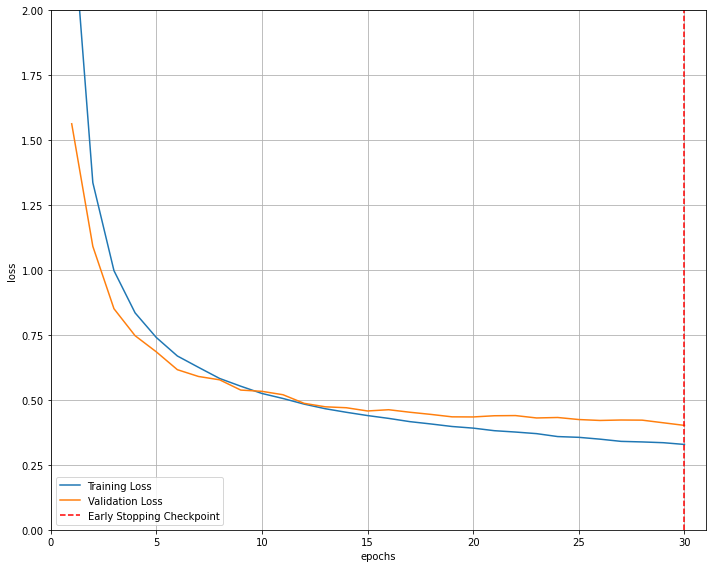

In [7]:
def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_valid_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_avg_loss_per_epoch(train_losses, valid_losses)

100%|██████████| 172/172 [00:03<00:00, 56.77it/s]


Acc: 0.8778736937755566
Confusion Matrix Without Normalization


<Figure size 1080x576 with 0 Axes>

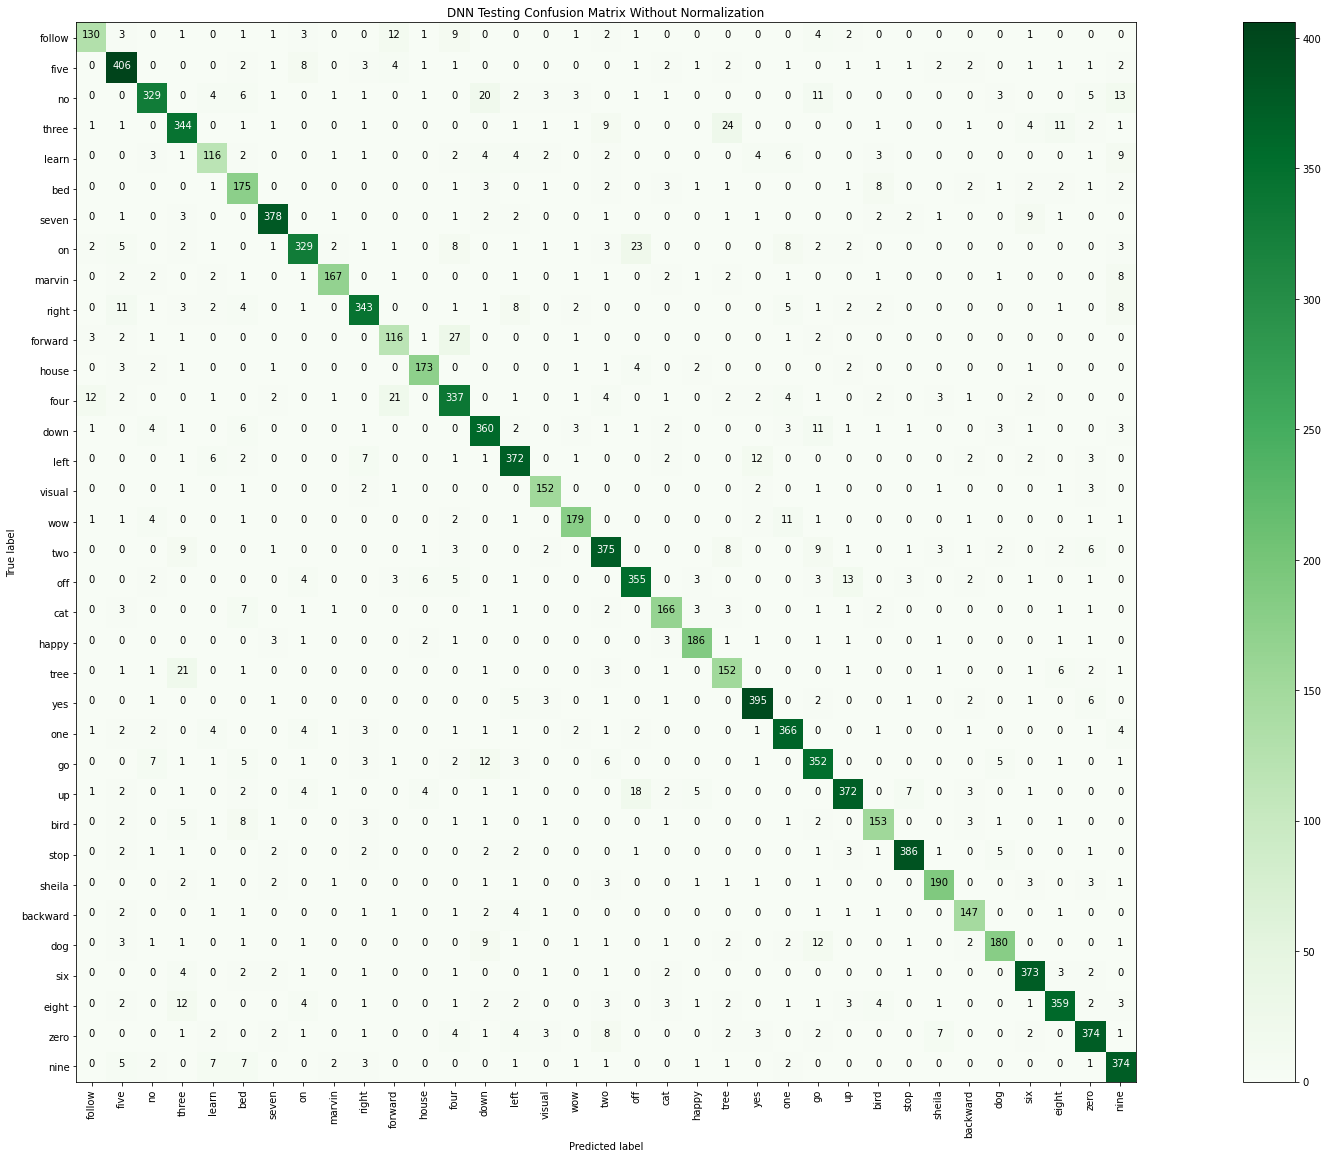

Normalized Confusion Matrix


<Figure size 1080x576 with 0 Axes>

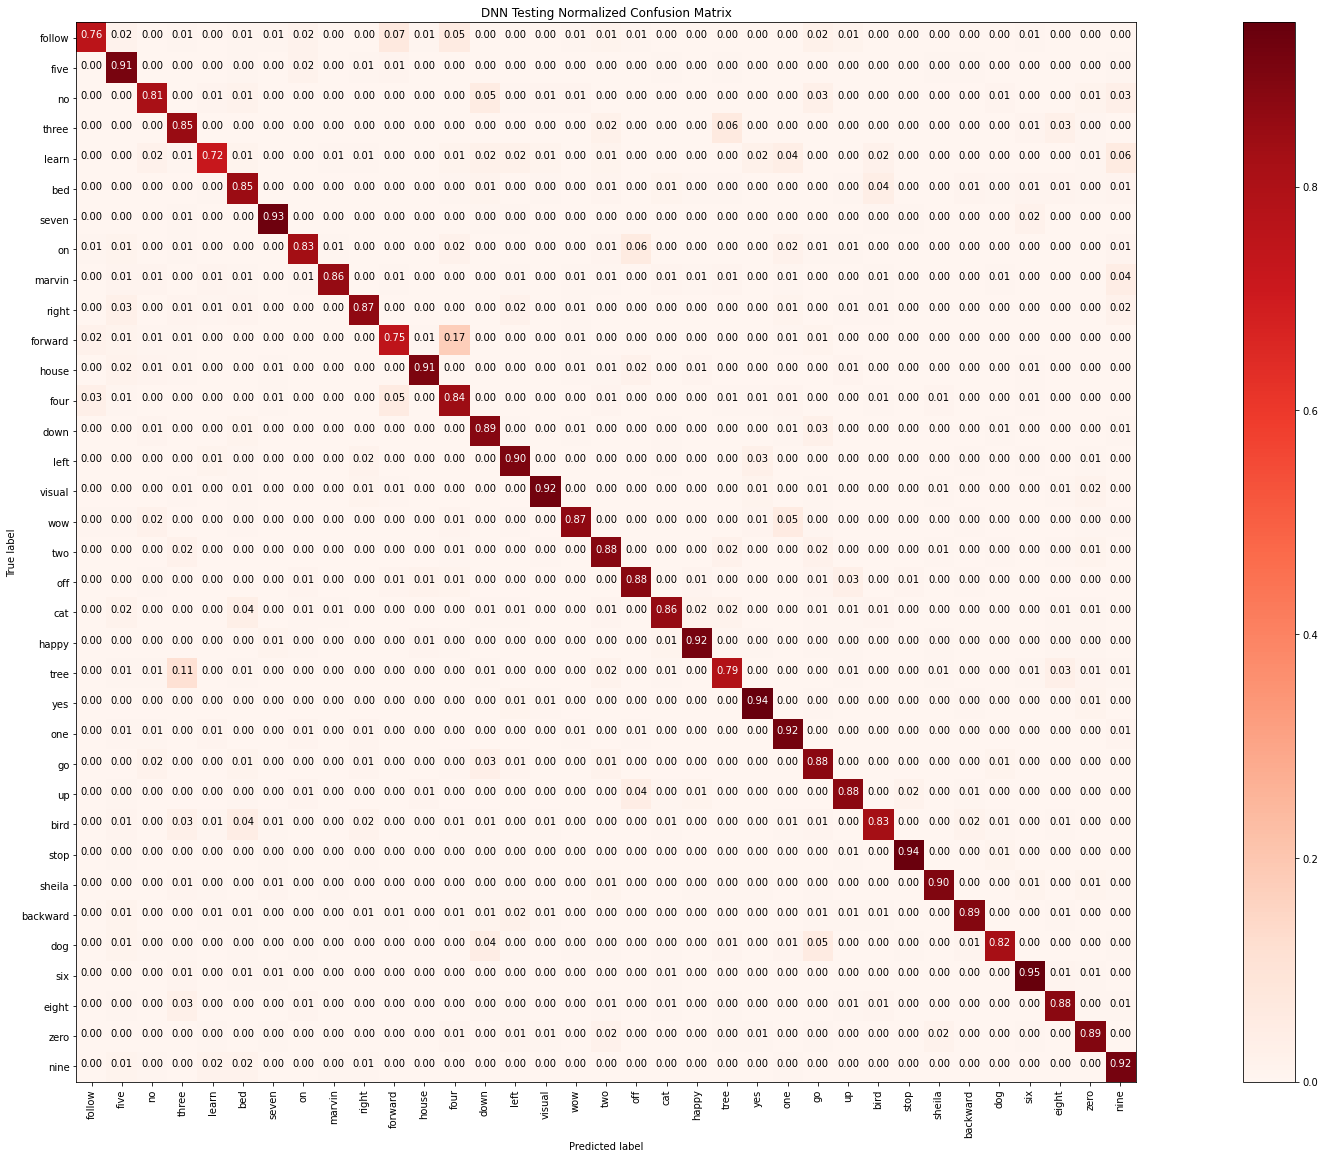

In [8]:
import itertools

from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(30,16))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

test_dataset = MySpeechCommandsDataset(dataset=testing_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, num_workers=2, shuffle=True)
_, test_acc, _, expected, actual = validate(model, test_loader, criterion)
print("Acc:", test_acc)

cnf_matrix = confusion_matrix(expected, actual)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=labels, title='DNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True, title='DNN Testing Normalized Confusion Matrix')

plt.show()